# Linear Regression

In [1]:
%matplotlib inline

from __future__ import print_function
from statsmodels.compat import lzip
import statsmodels
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import json
from pymongo import MongoClient
from bson.objectid import ObjectId

import pickle 

from statsmodels.stats.outliers_influence import OLSInfluence

In [2]:
def variable_diagnostics(results):
    # Normality of the residuals, Jarque-Bera test
    name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
    test = sms.jarque_bera(results.resid)
    lzip(name, test)
    
    # Influence
    test_class = OLSInfluence(results)
    test_class.dfbetas[:5,:]
    
    # Multicolinearity, conditional number
    np.linalg.cond(results.model.exog)
    
    # Heteroskedasticity, Breush-Pagan test:    
    name = ['Lagrange multiplier statistic', 'p-value', 
            'f-value', 'f p-value']
    test = sms.het_breushpagan(results.resid, results.model.exog)
    lzip(name, test)
    
    # Linearity, 
    name = ['t value', 'p value']
    test = sms.linear_harvey_collier(results)
    lzip(name, test)

In [47]:
# Import cleaned listing data

client = MongoClient()
db = client.property_investor
listings = db.listings
cursor = listings.find()
df = pd.DataFrame(list(cursor))

print(df.shape)
df.head()

(1634, 33)


,_id,address,annual_income,baths,beds,city,cluster,cost_square_feet,days_on_market,description_text,...,state,unit_1_beds,unit_2_beds,unit_3_beds,unit_4_beds,unit_rent,url,year_built,year_built_adjusted,zip
0,58b5f1b0dcc9d8d448be2325,3039 Bryant Ave S,85440.0,1.0,4.0,Minneapolis,7.0,174.0,1.0,Great investment opportunity in the heart of U...,...,MN,1.0,1.0,1.0,1.0,775.0,http://www.redfin.com/MN/Minneapolis/3039-Brya...,1913.0,63.0,55408
1,58b5f1b0dcc9d8d448be2326,3307 29th Ave S,19704.0,2.0,3.0,Minneapolis,2.0,123.0,1.0,"New windows, siding, foundation, updated bathr...",...,MN,2.0,1.0,NaN,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3307-29th...,1900.0,50.0,55406
2,58b5f1b0dcc9d8d448be2328,3540 Bloomington Ave,74112.0,1.0,8.0,Minneapolis,0.0,59.0,3.0,"great investment property , great location. Cu...",...,MN,2.0,2.0,2.0,2.0,NaN,http://www.redfin.com/MN/Minneapolis/3540-Bloo...,1928.0,78.0,55407
3,58b5f1b0dcc9d8d448be2329,3028 Fillmore St NE,60480.0,3.0,5.0,Minneapolis,8.0,125.0,3.0,Beautiful Audobon Park duplex that is owner oc...,...,MN,3.0,2.0,1.0,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3028-Fill...,1935.0,85.0,55418
4,58b5f1b0dcc9d8d448be232a,3945 Van Nest Ave,49536.0,1.0,3.0,Minneapolis,1.0,120.0,3.0,This classic Minneapolis duplex is filled with...,...,MN,1.0,1.0,1.0,NaN,NaN,http://www.redfin.com/MN/Minneapolis/3945-Van-...,1891.0,41.0,55409


In [48]:
df['year_built'] = df['year_built'] - 1850

In [49]:
df['income_ratio'] = df['annual_income']/df['price']

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 34 columns):
_id                    1634 non-null object
address                1601 non-null object
annual_income          1634 non-null float64
baths                  1497 non-null float64
beds                   1606 non-null float64
city                   1633 non-null object
cluster                391 non-null float64
cost_square_feet       601 non-null float64
days_on_market         1562 non-null float64
description_text       391 non-null object
hoa_per_month          0 non-null float64
latitude               1633 non-null float64
location               1632 non-null object
longitude              1633 non-null float64
lot_size               1373 non-null float64
mls_num                1634 non-null object
monthly_rents          1634 non-null float64
num_units              1492 non-null float64
price                  1535 non-null float64
property_type          1633 non-null object
rent_i

In [51]:
df.columns

Index(['_id', 'address', 'annual_income', 'baths', 'beds', 'city', 'cluster',
       'cost_square_feet', 'days_on_market', 'description_text',
       'hoa_per_month', 'latitude', 'location', 'longitude', 'lot_size',
       'mls_num', 'monthly_rents', 'num_units', 'price', 'property_type',
       'rent_index', 'source', 'square_feet', 'state', 'unit_1_beds',
       'unit_2_beds', 'unit_3_beds', 'unit_4_beds', 'unit_rent', 'url',
       'year_built', 'year_built_adjusted', 'zip', 'income_ratio'],
      dtype='object')

In [121]:
subset = ['price', 'lot_size',\
          'num_units', 'square_feet']

In [122]:
df_subset = df[subset]
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1634 entries, 0 to 1633
Data columns (total 4 columns):
price          1535 non-null float64
lot_size       1373 non-null float64
num_units      1492 non-null float64
square_feet    601 non-null float64
dtypes: float64(4)
memory usage: 51.1 KB


In [123]:
df_subset = df_subset.dropna()
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 411 entries, 0 to 1633
Data columns (total 4 columns):
price          411 non-null float64
lot_size       411 non-null float64
num_units      411 non-null float64
square_feet    411 non-null float64
dtypes: float64(4)
memory usage: 16.1 KB


In [124]:
model_df = df_subset[np.abs(df_subset.price-df_subset.price.mean())<=(3*df_subset.price.std())]

In [125]:
# Add Dummies
# dummies = ['city']
# model_df = pd.get_dummies(df_subset, columns=dummies, drop_first=True)
# model_df['Intercept'] = 1

In [126]:
df_corr = model_df.corr()
df_corr

,price,lot_size,num_units,square_feet
price,1.000000,-0.001759,0.371662,0.240673
lot_size,-0.001759,1.000000,-0.025398,-0.003014
num_units,0.371662,-0.025398,1.000000,0.417249
square_feet,0.240673,-0.003014,0.417249,1.000000


In [127]:
df_corr['price'].sort_values(ascending = False)

price          1.000000
num_units      0.371662
square_feet    0.240673
lot_size      -0.001759
Name: price, dtype: float64

## OLS

In [128]:
# Fit regression model
X = model_df.ix[:,1:]
y = model_df['price']

In [129]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4444)

results = sm.OLS(y,X).fit()
# Inspect the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     158.0
Date:                Thu, 09 Mar 2017   Prob (F-statistic):           1.57e-67
Time:                        16:27:31   Log-Likelihood:                -5807.3
No. Observations:                 403   AIC:                         1.162e+04
Df Residuals:                     400   BIC:                         1.163e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
lot_size        0.0004      0.004      0.101      0.919        -0.008     0.009
num_units    1.609e+05   1.52e+04     10.579      0.000      1.31e+05  1.91e+05
square_feet    23.3361     11.517      2.026      0.043         0.694    45.978
==============================================================================
Omnibus:                       67.323   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.676
Skew:                           1.116   Prob(JB):                     6.17e-22
Kurtosis:                       3.914   Cond. No.                     3.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

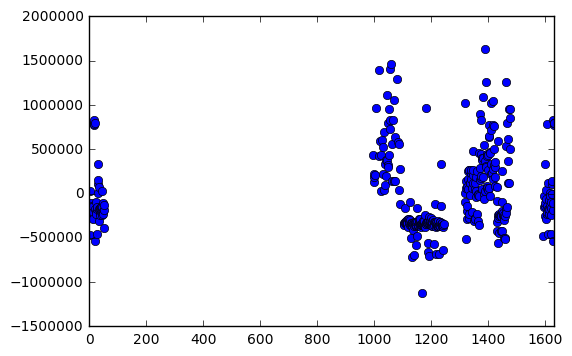

In [130]:
results.resid.plot(style='o')

## Setup for one cluster

In [36]:
df_cluster1 = df[df['cluster'] == 1]

In [37]:
cluster1_subset = ['price', 'city', 'days_on_market','income_ratio',\
          'lot_size','num_units', 'rent_index', 'square_feet', 'year_built']

In [38]:
df_cluster1_subset = df_cluster1[cluster1_subset]
df_cluster1_subset = df_cluster1_subset.dropna()

df_cluster1_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 0 to 50
Data columns (total 9 columns):
price             24 non-null float64
city              24 non-null object
days_on_market    24 non-null float64
income_ratio      24 non-null float64
lot_size          24 non-null float64
num_units         24 non-null int64
rent_index        24 non-null float64
square_feet       24 non-null float64
year_built        24 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.9+ KB


In [39]:
# Add Dummies
dummies = ['city']
model_df_cluster1 = pd.get_dummies(df_cluster1_subset, columns=dummies, drop_first=True)
model_df_cluster1['Intercept'] = 1

In [40]:
df_cluster1_corr = model_df_cluster1.corr()
df_cluster1_corr

,price,days_on_market,income_ratio,lot_size,num_units,rent_index,square_feet,year_built,city_St. Paul,Intercept
price,1.000000,0.261250,-0.579850,-0.163717,0.625326,0.169192,0.722205,0.603061,-0.193546,NaN
days_on_market,0.261250,1.000000,-0.071696,0.165935,-0.140581,-0.026111,0.176066,-0.028158,-0.061478,NaN
income_ratio,-0.579850,-0.071696,1.000000,0.027618,-0.248362,0.037269,-0.441416,-0.373105,-0.011627,NaN
lot_size,-0.163717,0.165935,0.027618,1.000000,-0.353974,0.091433,-0.106378,-0.078997,-0.012155,NaN
num_units,0.625326,-0.140581,-0.248362,-0.353974,1.000000,0.202883,0.622614,0.506615,-0.072357,NaN
rent_index,0.169192,-0.026111,0.037269,0.091433,0.202883,1.000000,-0.248049,-0.135686,-0.201020,NaN
square_feet,0.722205,0.176066,-0.441416,-0.106378,0.622614,-0.248049,1.000000,0.798012,0.108360,NaN
year_built,0.603061,-0.028158,-0.373105,-0.078997,0.506615,-0.135686,0.798012,1.000000,0.173992,NaN
city_St. Paul,-0.193546,-0.061478,-0.011627,-0.012155,-0.072357,-0.201020,0.108360,0.173992,1.000000,NaN
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
df_cluster1_corr['price'].sort_values(ascending = False)

price             1.000000
square_feet       0.722205
num_units         0.625326
year_built        0.603061
days_on_market    0.261250
rent_index        0.169192
lot_size         -0.163717
city_St. Paul    -0.193546
income_ratio     -0.579850
Intercept              NaN
Name: price, dtype: float64

## Cluster 1 OLS

In [42]:
# Fit regression model
X1 = model_df_cluster1.ix[:,1:]
y1 = model_df_cluster1['price']

In [43]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=4444)

results1 = sm.OLS(y1,X1).fit()
# Inspect the results
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     7.772
Date:                Wed, 08 Mar 2017   Prob (F-statistic):           0.000372
Time:                        22:31:14   Log-Likelihood:                -300.94
No. Observations:                  24   AIC:                             619.9
Df Residuals:                      15   BIC:                             630.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
days_on_market   311.7417    205.410      1.518      0.150      -126.079   749.562
income_ratio    -6.36e+05   2.74e+05     -2.320      0.035     -1.22e+06 -5.16e+04
lot_size         -11.3167     13.296     -0.851      0.408       -39.656    17.022
num_units       3.578e+04   5.37e+04      0.667      0.515     -7.86e+04   1.5e+05
rent_index      2.715e+05   1.56e+05      1.742      0.102     -6.07e+04  6.04e+05
square_feet       56.5338     37.183      1.520      0.149       -22.719   135.787
year_built       901.6726   1201.065      0.751      0.464     -1658.338  3461.683
city_St. Paul  -6.049e+04   3.66e+04     -1.654      0.119     -1.38e+05  1.75e+04
Intercept      -6.505e+04   1.69e+05     -0.386      0.705     -4.25e+05  2.94e+05
==============================================================================
Omnibus:                        3.483   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                1.812
Skew:                          -0.562   Prob(JB):                        0.404
Kurtosis:                       3.740   Cond. No.                     1.02e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Lasso

In [131]:
# Scale X

scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [132]:
# Create LassoCV object; set seed for reproducibility
lasso_cv = linear_model.LassoCV(cv=5, normalize=False, verbose=True, random_state=42)

# Create model
lasso_cv.fit(X_scaled, y)

# Print the coeficientents

lasso_cv.coef_

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


array([     0.        ,  88487.88410875,      0.        ])

In [133]:
lasso_cv.score(X_scaled, y)

0.10391616613065581